In [1]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

## 1. Data preprocessing

In [3]:
#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/mel-data/data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 520 files belonging to 2 classes.


In [4]:
#Getting the class names
classes = dataset.class_names
classes

['healthy', 'unhealthy']

In [6]:
#A batch of 32 and each image has size of 256 * 256 pixels
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]


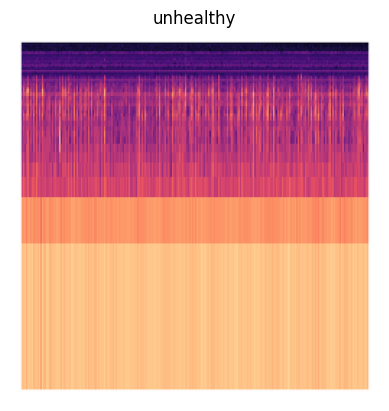

In [7]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

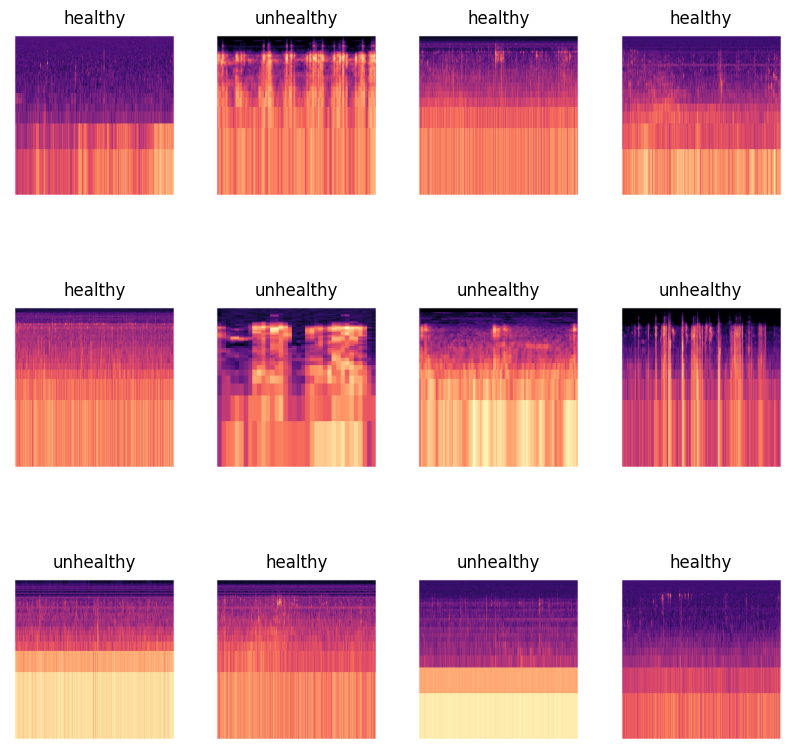

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

## 2. Splitting the data

In [10]:
#Getting the train size for the dataset
train_size = 0.8
train_samples = int(len(dataset) * train_size)  # Truncates decimal part
train_samples

13

In [11]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Function to apply time shifting
def time_shift(spec, max_shift=5):
    num_time_steps = tf.shape(spec)[1]
    shift = tf.random.uniform([], minval=-max_shift, maxval=max_shift, dtype=tf.int32)
    return tf.roll(spec, shift=shift, axis=1)

# Function to apply Gaussian noise injection
def add_gaussian_noise(spec, stddev=0.01):
    noise = tf.random.normal(shape=tf.shape(spec), mean=0.0, stddev=stddev, dtype=tf.float32)
    return spec + noise

In [16]:
# Combine augmentation techniques into a single function
def augment_mel(spec):
    spec = time_shift(spec, max_shift=5)
    spec = add_gaussian_noise(spec, stddev=0.02)
    return spec

# Apply augmentation in the dataset pipeline
train_ds = train_ds.map(lambda x, y: (augment_mel(x), y))

In [17]:
# Preprocessing the images (normalization and data augmentation)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

## 3. Model Training

In [18]:
#Importing the pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [19]:
# Pre-trained model, VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stopping],
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 629ms/step - accuracy: 0.5571 - loss: 0.7046 - val_accuracy: 0.4375 - val_loss: 0.7234
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5305 - loss: 0.6875 - val_accuracy: 0.7500 - val_loss: 0.6116
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7259 - loss: 0.5907 - val_accuracy: 0.8125 - val_loss: 0.5679
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7829 - loss: 0.5458 - val_accuracy: 0.8438 - val_loss: 0.5426
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8450 - loss: 0.4937 - val_accuracy: 0.8125 - val_loss: 0.5244
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7940 - loss: 0.4763 - val_accuracy: 0.7500 - val_loss: 0.4977
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8556 - loss: 0.4535 - val_accuracy: 0.8438 - val_loss: 0.4582
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8712 - loss: 0.4008 - val_accuracy: 0

In [25]:
from sklearn.metrics import classification_report
import numpy as np

# Getting the predicted probabilities
y_pred_probs = model.predict(val_ds)

# Converting the probabilities to binary labels
y_pred = (y_pred_probs > 0.5).astype("int32")

# Extracting true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Printing the classification report
print(classification_report(y_true, y_pred, target_names=["Healthy", "Unhealthy"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
              precision    recall  f1-score   support

     Healthy       0.86      1.00      0.92        18
   Unhealthy       1.00      0.79      0.88        14

    accuracy                           0.91        32
   macro avg       0.93      0.89      0.90        32
weighted avg       0.92      0.91      0.90        32



In [26]:
# Saving the model
model.save('audio_classification_model.h5')

First image to predict:


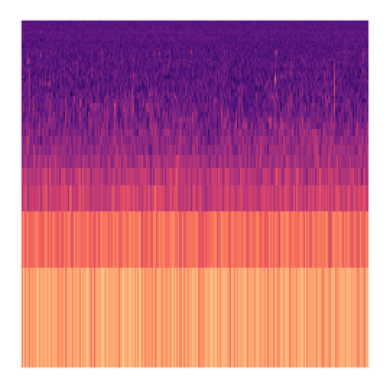

Actual label on dataset: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label by model: healthy


In [30]:
import numpy as np
import matplotlib.pyplot as plt

for images_batch, labels_batch in test_ds.take(1):
    img_1 = images_batch[0].numpy()
    img_1 = (img_1 * 255).astype('uint8')

    img1_label = labels_batch[0].numpy()

    print('First image to predict:')
    plt.imshow(img_1.squeeze(), cmap="inferno")
    plt.axis("off")
    plt.show()

    print('Actual label on dataset:', classes[img1_label])

    batch_prediction = model.predict(images_batch)
    print('Predicted label by model:', classes[np.argmax(batch_prediction[0])])


In [38]:
# Getting the MSE

train_loss = model.evaluate(train_ds)
test_loss = model.evaluate(test_ds)

train_mse = train_loss[0] if isinstance(train_loss, list) else train_loss
test_mse = test_loss[0] if isinstance(test_loss, list) else test_loss

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9101 - loss: 0.3223
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9023 - loss: 0.3259
Train MSE: 0.3200
Test MSE: 0.3172
